In [25]:
import ccxt
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
SYMBOL = 'ETH/USDT'
TIMEFRAME = '1h'  # 1-hour candles
LIMIT = 1000      # Number of candles to fetch

# Initialize Exchange (Public API)
exchange = ccxt.binance({
    'enableRateLimit': True, 
})

print(f"✅ Initialized {exchange.name} successfully.")

✅ Initialized Binance successfully.


In [26]:
def fetch_historical_data(symbol, timeframe, limit):
    """
    Fetches OHLCV data and returns a clean Pandas DataFrame.
    """
    print(f"Fetching {limit} {timeframe} candles for {symbol}...")
    
    # fetch_ohlcv returns a list of lists
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
    
    # Load directly into DataFrame (Fixes the read_json error)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    
    # Convert timestamp to datetime and set index
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('datetime', inplace=True)
    
    # Ensure numeric types
    numeric_cols = ['open', 'high', 'low', 'close', 'volume']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, axis=1)
    
    return df

# Run the function
df = fetch_historical_data(SYMBOL, TIMEFRAME, LIMIT)
print(f"Data Loaded: {df.shape}")
display(df.head(3))

Fetching 1000 1h candles for ETH/USDT...
Data Loaded: (1000, 6)


,timestamp,open,high,low,close,volume
datetime,,,,,,
2025-12-08 01:00:00,1765155600000,3063.23,3134.73,3062.74,3098.25,32047.6100
2025-12-08 02:00:00,1765159200000,3098.26,3114.99,3092.40,3109.77,10311.0787
2025-12-08 03:00:00,1765162800000,3109.78,3120.50,3101.55,3111.01,8976.9189


In [27]:
# 1. Stationary Features (Log Returns)
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))

# 2. Technical Indicators (RSI, MACD, ATR)
df.ta.rsi(length=14, append=True)
df.ta.macd(fast=12, slow=26, signal=9, append=True)
df.ta.atr(length=14, append=True)

# 3. Threshold Analysis (Finding the Sweet Spot)
# We check how many "Buy" signals exist at different return thresholds.
print("--- Target Balance Analysis ---")
thresholds = [0.0, 0.001, 0.002, 0.003]
for t in thresholds:
    temp_target = (df['log_returns'].shift(-1) > t).astype(int)
    percent = (temp_target.sum() / len(df)) * 100
    print(f"Threshold > {t:.1%}: {percent:.1f}% Buys")

# 4. Set the Target
# We use 0.001 (0.1%) as a balance between profit and data availability.
# If you saw < 30% buys in the analysis above, change this back to 0.0
TARGET_THRESHOLD = 0.001 

df['target_direction'] = (df['log_returns'].shift(-1) > TARGET_THRESHOLD).astype(int)

# 5. Clean NaNs (created by shift and indicators)
df.dropna(inplace=True)
print(f"\nFinal Dataset Shape: {df.shape}")

--- Target Balance Analysis ---
Threshold > 0.0%: 51.8% Buys
Threshold > 0.1%: 37.6% Buys
Threshold > 0.2%: 25.6% Buys
Threshold > 0.3%: 18.4% Buys

Final Dataset Shape: (967, 13)


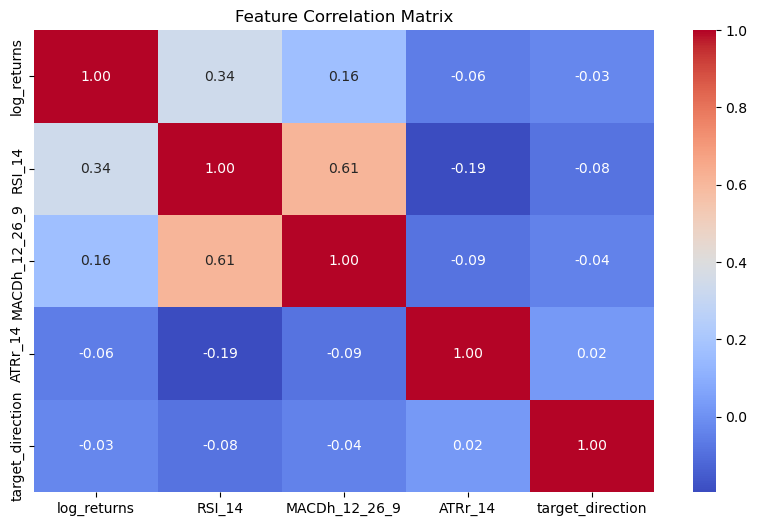

In [28]:
# Select features to visualize
features = ['log_returns', 'RSI_14', 'MACDh_12_26_9', 'ATRr_14', 'target_direction']

plt.figure(figsize=(10, 6))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

Training with Time Series Cross-Validation...

Fold 1: Accuracy = 0.5652
Fold 2: Accuracy = 0.5466
Fold 3: Accuracy = 0.5652
Fold 4: Accuracy = 0.5776
Fold 5: Accuracy = 0.6335

Average Accuracy: 0.5776


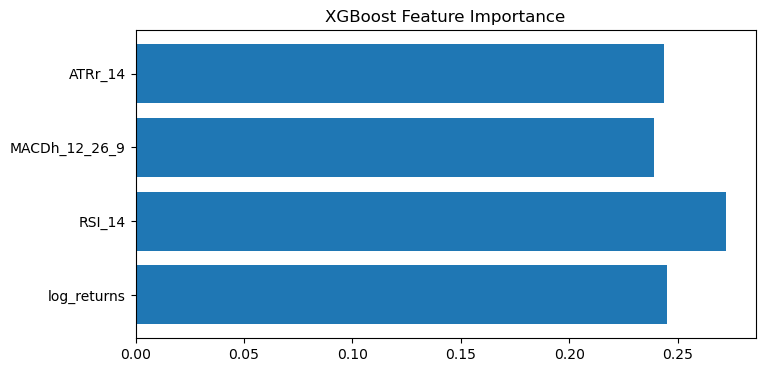

In [29]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, classification_report

# Setup Features (X) and Target (y)
feature_cols = ['log_returns', 'RSI_14', 'MACDh_12_26_9', 'ATRr_14']
X = df[feature_cols]
y = df['target_direction']

# Time Series Split (5 Folds)
tscv = TimeSeriesSplit(n_splits=5)
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, eval_metric='logloss', random_state=42)

print("Training with Time Series Cross-Validation...\n")

fold = 1
accuracies = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    print(f"Fold {fold}: Accuracy = {acc:.4f}")
    fold += 1

print(f"\nAverage Accuracy: {np.mean(accuracies):.4f}")

# Feature Importance Plot
plt.figure(figsize=(8, 4))
plt.barh(feature_cols, model.feature_importances_)
plt.title("XGBoost Feature Importance")
plt.show()

<Figure size 600x600 with 0 Axes>

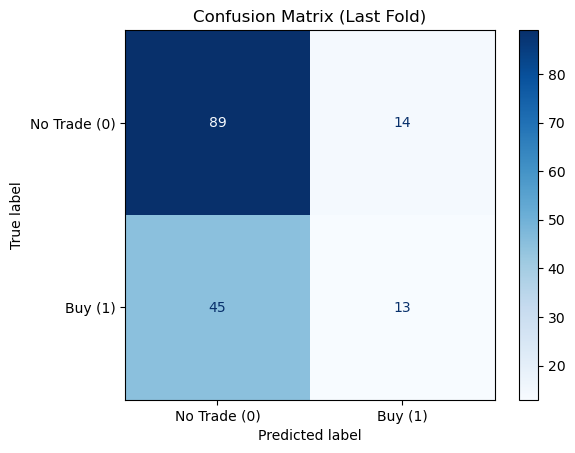

--- Strategy Performance (Threshold > 0.25) ---
Precision: 0.3636 (Win Rate)
Trades Taken: 132 (out of 161 hours)


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Confusion Matrix (Last Fold)
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Trade (0)', 'Buy (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Last Fold)')
plt.show()

# 2. Probability Threshold Tuner
# We filter for high-confidence trades only.
probs_up = model.predict_proba(X_test)[:, 1]

# Try changing this to see how precision improves!
CONFIDENCE_THRESHOLD = 0.25

custom_preds = (probs_up > CONFIDENCE_THRESHOLD).astype(int)
new_prec = precision_score(y_test, custom_preds, zero_division=0)
num_trades = np.sum(custom_preds)

print(f"--- Strategy Performance (Threshold > {CONFIDENCE_THRESHOLD}) ---")
print(f"Precision: {new_prec:.4f} (Win Rate)")
print(f"Trades Taken: {num_trades} (out of {len(y_test)} hours)")

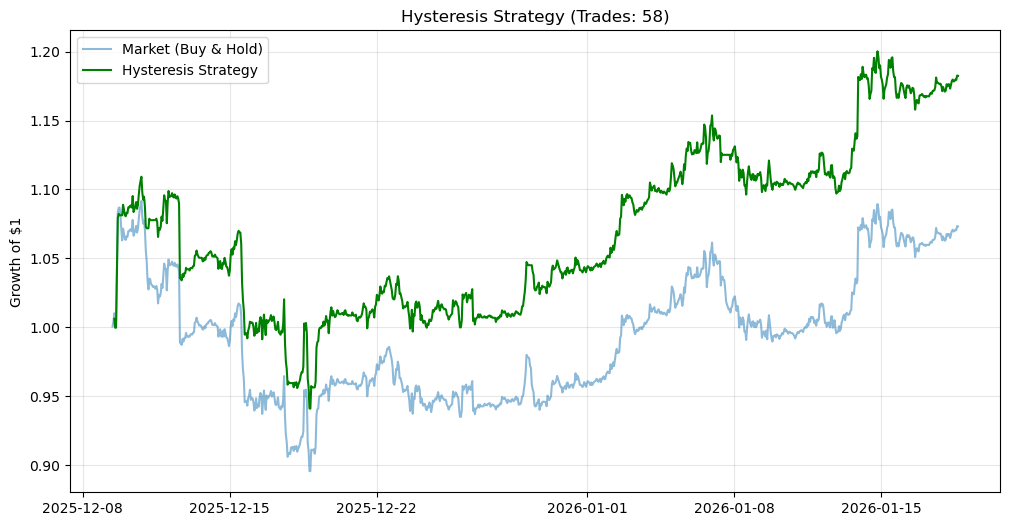

Total Return: 18.25%
Total Fees Paid: 5.80%
Trade Count: 58


In [ ]:
# -----------------------------------------------------------------------------
# 7. Advanced Backtest (Hysteresis / Smoothing)
# -----------------------------------------------------------------------------

# Parameters
UPPER_THRESHOLD = 0.30  # Buy when confident
LOWER_THRESHOLD = 0.15  # Sell only when signal is weak
FEE_RATE = 0.001        # 0.1%

# 1. Generate Raw Probabilities
probs = model.predict_proba(X)[:, 1]

# 2. Hysteresis Loop
# We need to iterate because current position depends on PREVIOUS position
positions = []
current_pos = 0

for p in probs:
    if p > UPPER_THRESHOLD:
        current_pos = 1  # Enter Long
    elif p < LOWER_THRESHOLD:
        current_pos = 0  # Exit / Cash
    else:
        # p is between 0.15 and 0.30
        # KEEP PREVIOUS POSITION (Do nothing)
        pass 
    
    positions.append(current_pos)

# 3. Create DataFrame Columns
df['signal'] = positions
df['signal'] = df['signal'].shift(1) # Shift to apply to NEXT candle

# 4. Calculate PnL
df['strategy_raw'] = df['signal'] * df['log_returns']
df['trades'] = df['signal'].diff().abs()
df['strategy_net'] = df['strategy_raw'] - (df['trades'] * FEE_RATE)

df['cumulative_market'] = df['log_returns'].cumsum().apply(np.exp)
df['cumulative_strategy'] = df['strategy_net'].cumsum().apply(np.exp)

# 5. Stats
total_return = df['cumulative_strategy'].iloc[-1] - 1
total_fees = (df['trades'].sum() * FEE_RATE)
trade_count = df['trades'].sum()

# 6. Visualization
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['cumulative_market'], label='Market (Buy & Hold)', alpha=0.5)
plt.plot(df.index, df['cumulative_strategy'], label='Hysteresis Strategy', color='green')

plt.title(f"Hysteresis Strategy (Trades: {int(trade_count)})")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total Return: {total_return:.2%}")
print(f"Total Fees Paid: {total_fees:.2%}")
print(f"Trade Count: {int(trade_count)}")

In [32]:
# Filter for only the hours where we were holding the position
active_hours = df[df['signal'] == 1].copy()

# 1. Active Accuracy (Do we hold during Green candles?)
active_win_rate = (active_hours['log_returns'] > 0).mean()

# 2. Average Hourly Return (Quality of hold)
avg_active_return = active_hours['log_returns'].mean()
avg_market_return = df['log_returns'].mean()

print(f"--- Hysteresis Performance Diagnostics ---")
print(f"Active Candle Win Rate: {active_win_rate:.2%}")
print(f"Avg Return per Active Hour: {avg_active_return:.5f}")
print(f"Avg Return per Market Hour: {avg_market_return:.5f}")

if avg_active_return > avg_market_return:
    print("✅ Conclusion: You are holding during better-than-average times.")
else:
    print("❌ Conclusion: You are holding through too much noise/downturns.")

--- Hysteresis Performance Diagnostics ---
Active Candle Win Rate: 58.16%
Avg Return per Active Hour: 0.00058
Avg Return per Market Hour: 0.00007
✅ Conclusion: You are holding during better-than-average times.


In [33]:
# Save the trained model to a file
model.save_model("model.json")
print("✅ Model saved to model.json")

✅ Model saved to model.json
